# This notebook serves as an appendix to the blog written by me at https://blog-page-lake-phi.vercel.app/autoencoder-blog.html. 
## Github Repo: https://github.com/soumyasavarn/Blog_page
## Dataset used is MNIST for demonstration purpose as it is easy to train and experiment. In Multimodal generation part, I have used its label as text input for the Text Encoder.
## Framework used: PyTorch

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


2025-05-07 12:09:39.106200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746619779.296622      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746619779.355763      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Appendix 1

## PCA vs Linear Autoencoders
### Checking their equivalence

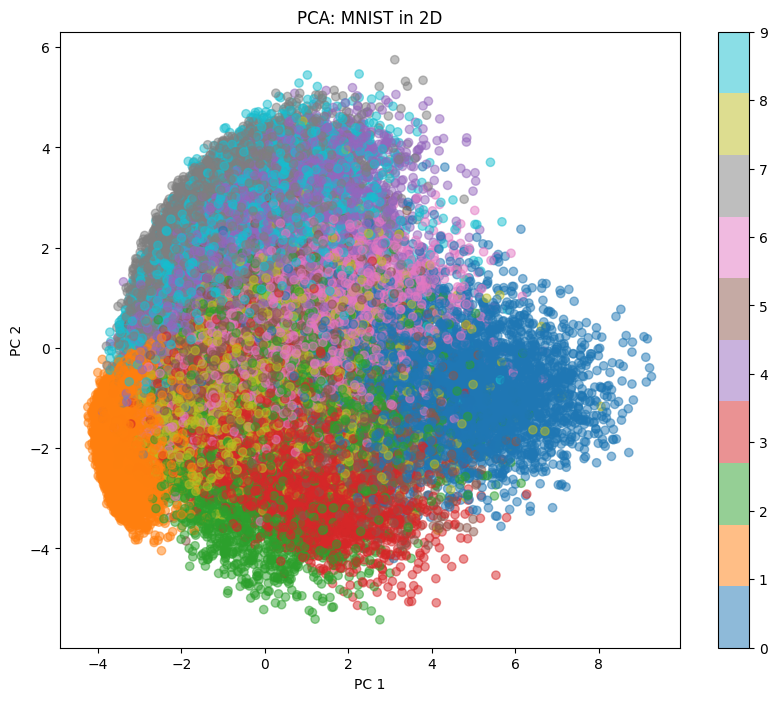

Using device: cuda
Epoch 1/10 — Train Loss: 0.0763
Epoch 2/10 — Train Loss: 0.0633
Epoch 3/10 — Train Loss: 0.0624
Epoch 4/10 — Train Loss: 0.0594
Epoch 5/10 — Train Loss: 0.0581
Epoch 6/10 — Train Loss: 0.0579
Epoch 7/10 — Train Loss: 0.0579
Epoch 8/10 — Train Loss: 0.0578
Epoch 9/10 — Train Loss: 0.0578
Epoch 10/10 — Train Loss: 0.0578


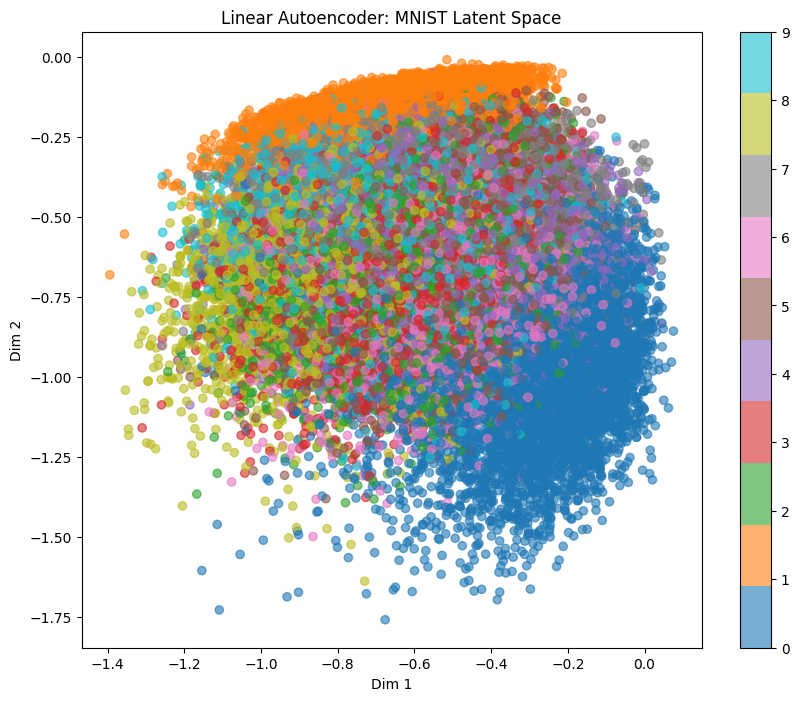

Average Test Loss: 0.0578


In [13]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(x_train_flat)
pca_train = pca.transform(x_train_flat)
pca_test  = pca.transform(x_test_flat)

plt.figure(figsize=(10,8))
plt.scatter(pca_train[:,0], pca_train[:,1], c=y_train, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title('PCA: MNIST in 2D')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train_t = torch.from_numpy(x_train_flat).float()
y_train_t = torch.from_numpy(y_train).long()
x_test_t  = torch.from_numpy(x_test_flat).float()
y_test_t  = torch.from_numpy(y_test).long()

train_ds = TensorDataset(x_train_t, y_train_t)
test_ds  = TensorDataset(x_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=100, shuffle=False)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
        self.decoder = nn.Linear(latent_dim, input_dim, bias=False)
    
    def forward(self, x):
        # x is already flat: [batch, 28*28]
        z     = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

input_dim  = 28 * 28
latent_dim = 2
model      = LinearAutoencoder(input_dim, latent_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        recon, _ = model(batch_x)
        loss = criterion(recon, batch_x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_x.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Train Loss: {epoch_loss:.4f}")

def visualize_latent(model, loader):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            _, z = model(batch_x)
            zs.append(z.cpu().numpy())
            labels.append(batch_y.numpy())
    zs     = np.vstack(zs)
    labels = np.concatenate(labels)
    
    plt.figure(figsize=(10,8))
    plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('Linear Autoencoder: MNIST Latent Space')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

visualize_latent(model, train_loader)

model.eval()
total_loss = 0.0
with torch.no_grad():
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        recon, _ = model(batch_x)
        total_loss += criterion(recon, batch_x).item() * batch_x.size(0)

avg_test_loss = total_loss / len(test_loader.dataset)
print(f"Average Test Loss: {avg_test_loss:.4f}")


## Conclusion: The structure of the classes are nearly same after rotation and shift. Actually, a theorem in recent paper proved their equivalence and stated the exact way how to get same results using linear autoencoders and PCA. 
### Additional remark: The loss of the linear autoencoder stopped falling cause the expressibility of the latent space reached its cap using linear activations.

# Non - Linear Autoencoder

Using device: cuda
Epoch  1/20 — Train loss: 0.0586
Epoch  2/20 — Train loss: 0.0487
Epoch  3/20 — Train loss: 0.0458
Epoch  4/20 — Train loss: 0.0437
Epoch  5/20 — Train loss: 0.0424
Epoch  6/20 — Train loss: 0.0415
Epoch  7/20 — Train loss: 0.0408
Epoch  8/20 — Train loss: 0.0402
Epoch  9/20 — Train loss: 0.0398
Epoch 10/20 — Train loss: 0.0395
Epoch 11/20 — Train loss: 0.0394
Epoch 12/20 — Train loss: 0.0390
Epoch 13/20 — Train loss: 0.0387
Epoch 14/20 — Train loss: 0.0385
Epoch 15/20 — Train loss: 0.0383
Epoch 16/20 — Train loss: 0.0381
Epoch 17/20 — Train loss: 0.0380
Epoch 18/20 — Train loss: 0.0379
Epoch 19/20 — Train loss: 0.0376
Epoch 20/20 — Train loss: 0.0376


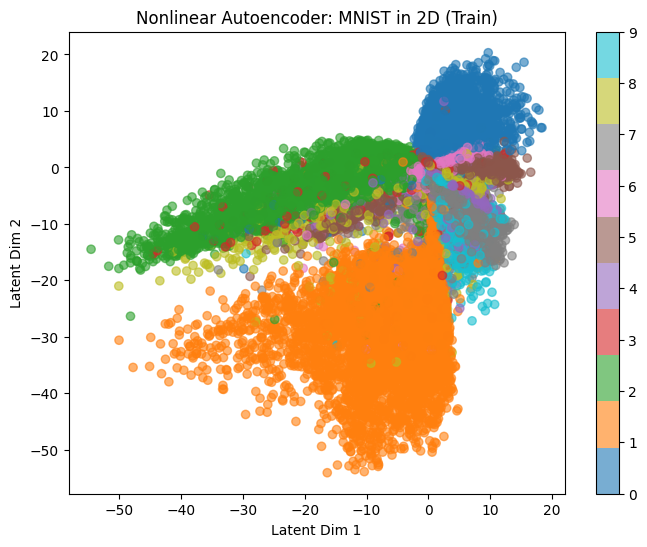

Avg test loss: 0.0380


In [14]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



x_train_t = torch.from_numpy(x_train_flat)
y_train_t = torch.from_numpy(y_train).long()
x_test_t  = torch.from_numpy(x_test_flat)
y_test_t  = torch.from_numpy(y_test).long()

train_ds = TensorDataset(x_train_t, y_train_t)
test_ds  = TensorDataset(x_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, latent_dim),     # <— no activation here
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),                 
        )
    
    def forward(self, x):
        # x is already [batch,784]
        z   = self.encoder(x)
        out = self.decoder(z)
        return out, z

model     = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    for xb, _ in train_loader:
        xb = xb.to(device)
        recon, _ = model(xb)
        loss = criterion(recon, xb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch:2d}/{num_epochs} — Train loss: {total_loss/len(train_loader.dataset):.4f}")

def plot_latent(loader, title):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            _, z = model(xb)
            zs.append(z.cpu().numpy())
            labels.append(yb.numpy())
    zs     = np.vstack(zs)
    labels = np.concatenate(labels)
    plt.figure(figsize=(8,6))
    plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.show()

plot_latent(train_loader, "Nonlinear Autoencoder: MNIST in 2D (Train)")

model.eval()
test_loss = 0
with torch.no_grad():
    for xb, _ in test_loader:
        xb    = xb.to(device)
        recon, _ = model(xb)
        test_loss += criterion(recon, xb).item() * xb.size(0)
print(f"Avg test loss: {test_loss/len(test_loader.dataset):.4f}")


## Conclusion: Results are way better than linear techniques

# t-SNE to 2 dimensions

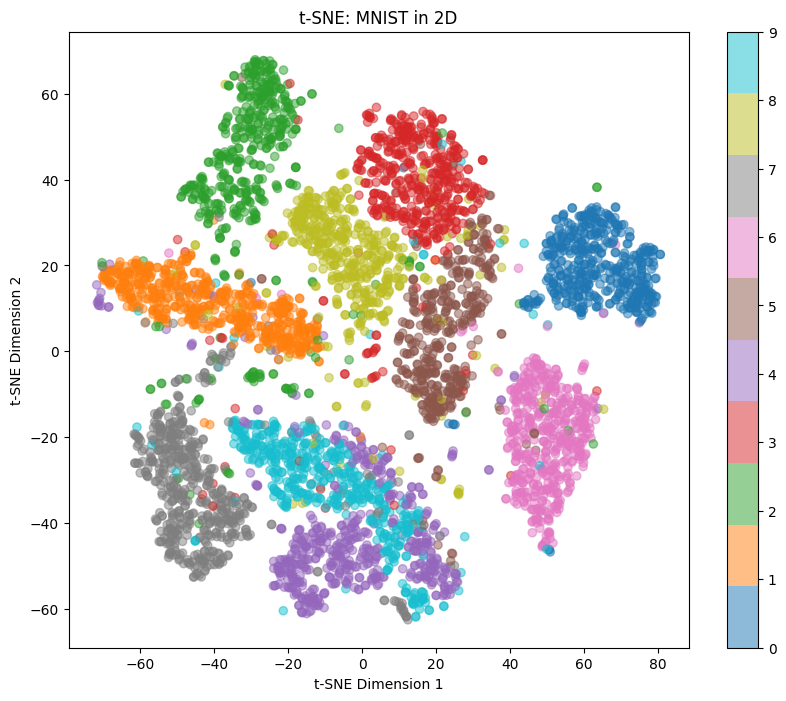

In [15]:
# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(x_train_flat[:5000])  # Using subset for speed

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train[:5000], cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title('t-SNE: MNIST in 2D')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


## Conclusion: Best dimensionality reduction technique so far (stochastic in nature)

# Appendix 2

## Moving to VAEs

Epoch 1, Loss: 172.8404
Epoch 2, Loss: 125.9831
Epoch 3, Loss: 118.0736
Epoch 4, Loss: 114.6168
Epoch 5, Loss: 112.4803
Epoch 6, Loss: 110.9451
Epoch 7, Loss: 109.7779
Epoch 8, Loss: 108.8092
Epoch 9, Loss: 108.0437
Epoch 10, Loss: 107.3048
Epoch 11, Loss: 106.7858
Epoch 12, Loss: 106.1865
Epoch 13, Loss: 105.7740
Epoch 14, Loss: 105.3291
Epoch 15, Loss: 105.0108
Epoch 16, Loss: 104.6103
Epoch 17, Loss: 104.3191
Epoch 18, Loss: 104.0761
Epoch 19, Loss: 103.7641
Epoch 20, Loss: 103.5387


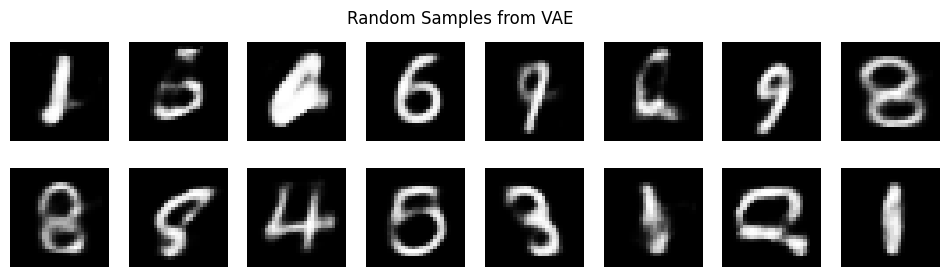

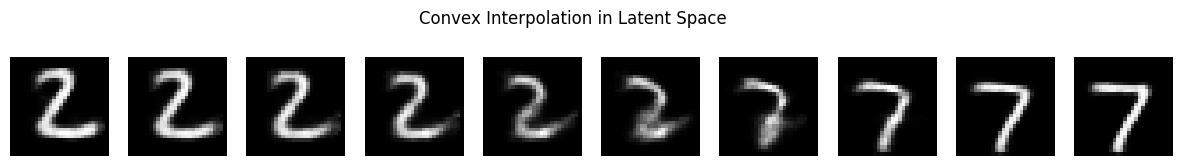

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
latent_dim = 8
epochs = 20
lr = 1e-3

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 28*28)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z.view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def vae_loss(x, x_recon, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')

vae.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = vae.decoder(z).cpu()
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle('Random Samples from VAE')
    plt.show()

# Convex interpolation between two images
def interpolate(img1, img2, steps=10):
    vae.eval()
    with torch.no_grad():
        mu1, logvar1 = vae.encoder(img1.unsqueeze(0).to(device))
        mu2, logvar2 = vae.encoder(img2.unsqueeze(0).to(device))
        z1 = vae.reparameterize(mu1, logvar1)
        z2 = vae.reparameterize(mu2, logvar2)
        imgs = []
        for alpha in np.linspace(0, 1, steps):
            z = alpha * z1 + (1 - alpha) * z2
            recon = vae.decoder(z)
            imgs.append(recon.cpu().squeeze().numpy())
        return imgs

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img1, _ = test_dataset[0]
img2, _ = test_dataset[1]

imgs = interpolate(img1, img2, steps=10)
plt.figure(figsize=(15, 2))
for i, img in enumerate(imgs):
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Convex Interpolation in Latent Space')
plt.show()


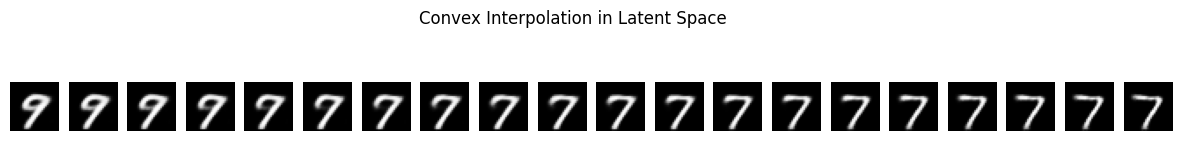

In [17]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img1, _ = test_dataset[0]
img2, _ = test_dataset[9]

imgs = interpolate(img1, img2, steps=20)
plt.figure(figsize=(15, 2))
for i, img in enumerate(imgs):
    plt.subplot(1, 20, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Convex Interpolation in Latent Space')
plt.show()

## Look, how we moved from 9 to 7 via a linear path in the latent space. It is very strange at first how linearity is working in such high dimensional space.
**Food for thought:** Think about this—what if we could map the voices of two famous singers, like Arijit Singh and Atif Aslam, and then find a smooth path from one voice to the other? Kind of like moving a slider from one style to the next. That would be amazing, right?

Now take it a step further—what if you could see how close your voice is to your favorite singer’s? Just like with face filters where you can see how your face compares to someone else’s, we could do something similar with voice. You could actually learn how your voice is different, and maybe even change it to sound more like theirs.

The idea sounds fun—and the possibilities are endless!



# Appendix 3:

# Implementation of "Multimodal Generative Models for Scalable Weakly-Supervised Learning"
## Link: https://arxiv.org/pdf/1802.05335

In [18]:
# ! pip install torch torchvision tqdm matplotlib transformers pillow

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

seed = 51
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [20]:
# Hyperparameters
latent_dim = 32
batch_size = 128
lr = 1e-3
epochs = 30  # increase as needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

I split the MNIST data into two groups:

1. **Paired data** (both image + label): Teaches the model how pictures and words go together.
2. **Unpaired data** (just images or just labels): Teaches each part (the image “expert” or the text “expert”) how to work on its own when the other bit is missing.

Doing both lets the model learn to fill in missing pieces—so at test time it can happily turn an image into a label or a label into an image.


In [21]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Creating paired subset  and large unimodal subsets
paired_indices = list(range(20000))
unpaired_img_indices = list(range(20000, len(mnist_train)))
unpaired_txt_indices = unpaired_img_indices.copy()

paired_loader = DataLoader(Subset(mnist_train, paired_indices), batch_size=batch_size, shuffle=True)
img_loader = DataLoader(Subset(mnist_train, unpaired_img_indices), batch_size=batch_size, shuffle=True)
txt_loader = DataLoader(Subset(mnist_train, unpaired_txt_indices), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class TextEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)
        )
    def forward(self, x):
        h = self.fc(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        return mu, logvar


class ImageEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            # 28×28 → 14×14
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # 14×14 → 7×7
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # deepen at 7×7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        self.fc_mu     = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

    def forward(self, x):
        h      = self.conv(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class ImageDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 128, 7, 7)
        return self.deconv(h)

class TextDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=-1)
        )
    def forward(self, z):
        return self.fc(z)


In [23]:
import torch

def poe(mu_list, lv_list, eps=1e-8):
    # convert log‐vars to precisions: τ = 1/var = exp(−lv)
    precisions = [torch.exp(-lv) for lv in lv_list]

    # sum of precisions
    precision_sum = torch.stack(precisions, dim=0).sum(dim=0) + eps

    # weighted sum of means: ∑ τᵢ μᵢ
    mu_prec = [mu * prec for mu, prec in zip(mu_list, precisions)]
    mu = torch.stack(mu_prec, dim=0).sum(dim=0) / precision_sum

    # combined log‐variance: lv = log(var) = −log(precision_sum)
    lv = -torch.log(precision_sum)

    return mu, lv

class MVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.E_img = ImageEncoder(latent_dim)
        self.E_txt = TextEncoder(latent_dim)
        self.D_img = ImageDecoder(latent_dim)
        self.D_txt = TextDecoder(latent_dim)

    def forward(self, x_img=None, x_txt=None):
        if x_img is not None:
            bs = x_img.size(0)
        elif x_txt is not None:
            bs = x_txt.size(0)
        else:
            raise ValueError("Must provide at least one modality")

        # collect experts
        mu_list, lv_list = [], []
        mu_list.append(torch.zeros(bs, latent_dim, device=device))
        lv_list.append(torch.zeros(bs, latent_dim, device=device))

        if x_img is not None:
            mu_i, lv_i = self.E_img(x_img)
            mu_list.append(mu_i); lv_list.append(lv_i)
        if x_txt is not None:
            mu_t, lv_t = self.E_txt(x_txt)
            mu_list.append(mu_t); lv_list.append(lv_t)

        # product-of-experts posterior
        mu, lv = poe(mu_list, lv_list)

        # reparameterization
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        z = mu + eps * std

        rec_img = self.D_img(z)
        rec_txt = self.D_txt(z)

        return mu, lv, z, rec_img, rec_txt


In [24]:
# ELBO loss
def elbo_loss(x_img, x_txt, rec_img, rec_txt, mu, lv):
    # Reconstruction
    rec_loss = 0
    if rec_img is not None:
        rec_loss += F.binary_cross_entropy(rec_img, x_img, reduction='sum')
    if rec_txt is not None:
        rec_loss += F.nll_loss(rec_txt, x_txt.argmax(dim=-1), reduction='sum')
    # KL
    kl = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
    return rec_loss + kl

In [25]:

model = MVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for (img_batch, lbl_batch), (img_u, _), ( _, lbl_u) in zip(paired_loader, img_loader, txt_loader):
        img_batch = img_batch.to(device)
        lbl_onehot = F.one_hot(lbl_batch, num_classes=10).float().to(device)
        img_u = img_u.to(device)
        lbl_u_onehot = F.one_hot(lbl_u, num_classes=10).float().to(device)
        optimizer.zero_grad()
        # Joint ELBO
        mu, lv, z, rec_img, rec_txt = model(x_img=img_batch, x_txt=lbl_onehot)
        loss_joint = elbo_loss(img_batch, lbl_onehot, rec_img, rec_txt, mu, lv)
        # Image-only
        mu_i, lv_i, z_i, rec_img_i, _ = model(x_img=img_u, x_txt=None)
        loss_img = elbo_loss(img_u, None, rec_img_i, None, mu_i, lv_i)
        # Text-only
        mu_t, lv_t, z_t, _, rec_txt_t = model(x_img=None, x_txt=lbl_u_onehot)
        loss_txt = elbo_loss(None, lbl_u_onehot, None, rec_txt_t, mu_t, lv_t)
        # Combine
        loss = loss_joint + loss_img + loss_txt
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(paired_loader):.4f}")

Epoch 1, Loss: 48673.6694
Epoch 2, Loss: 34618.4990
Epoch 3, Loss: 32217.8333
Epoch 4, Loss: 30266.9764
Epoch 5, Loss: 29016.1760
Epoch 6, Loss: 28459.5592
Epoch 7, Loss: 27961.7263
Epoch 8, Loss: 27446.6849
Epoch 9, Loss: 27056.7903
Epoch 10, Loss: 26696.8493
Epoch 11, Loss: 26505.7153
Epoch 12, Loss: 26270.7570
Epoch 13, Loss: 26165.3567
Epoch 14, Loss: 26046.5838
Epoch 15, Loss: 25821.9135
Epoch 16, Loss: 25685.4707
Epoch 17, Loss: 25557.6536
Epoch 18, Loss: 25491.1756
Epoch 19, Loss: 25317.6853
Epoch 20, Loss: 25293.9573
Epoch 21, Loss: 25195.2506
Epoch 22, Loss: 25168.9688
Epoch 23, Loss: 25075.5247
Epoch 24, Loss: 25030.3435
Epoch 25, Loss: 24935.0439
Epoch 26, Loss: 24936.0920
Epoch 27, Loss: 24860.0984
Epoch 28, Loss: 24764.4247
Epoch 29, Loss: 24794.4207
Epoch 30, Loss: 24693.9019


## Crossmodal Generation

#### Image to Label

True label: 7, Predicted label: 7


(-0.5, 27.5, 27.5, -0.5)

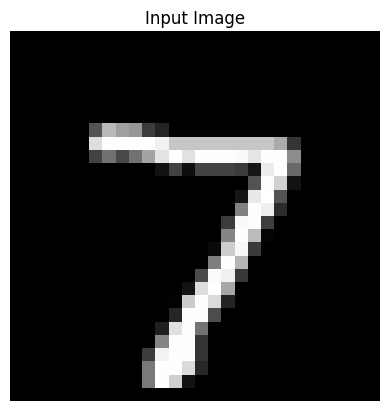

In [26]:
# Cross-modal generation demo
model.eval()
# Image -> Text
idx = 0
img, lbl = mnist_test[idx]
with torch.no_grad():
    mu, lv, z, rec_img, rec_txt = model(x_img=img.unsqueeze(0).to(device), x_txt=None)
pred_lbl = rec_txt.exp().cpu().numpy().argmax()
print(f"True label: {lbl}, Predicted label: {pred_lbl}")
plt.imshow(img.squeeze(), cmap='gray'); plt.title('Input Image'); plt.axis('off')


# Label to Image

(-0.5, 27.5, 27.5, -0.5)

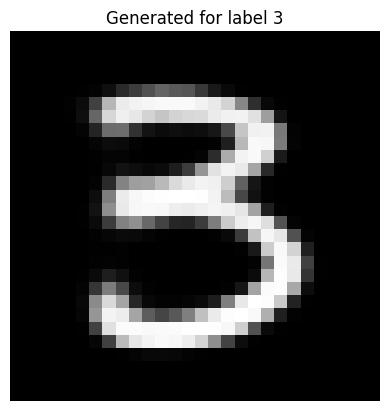

In [35]:
# Text -> Image
sample_label = 3
onehot = F.one_hot(torch.tensor([sample_label]), num_classes=10).float().to(device)
with torch.no_grad():
    mu, lv, z, rec_img_t2i, rec_txt_t2i = model(x_img=None, x_txt=onehot)
plt.figure()
plt.imshow(rec_img_t2i.cpu().squeeze(), cmap='gray'); plt.title(f'Generated for label {sample_label}'); plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

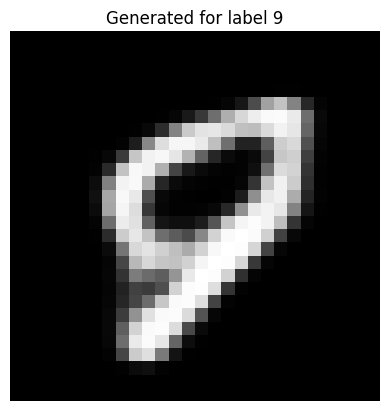

In [34]:
# Text -> Image
sample_label = 9
onehot = F.one_hot(torch.tensor([sample_label]), num_classes=10).float().to(device)
with torch.no_grad():
    mu, lv, z, rec_img_t2i, rec_txt_t2i = model(x_img=None, x_txt=onehot)
plt.figure()
plt.imshow(rec_img_t2i.cpu().squeeze(), cmap='gray'); plt.title(f'Generated for label {sample_label}'); plt.axis('off')

### For simplicity, I used One-Hot Encoding, you can try out BERT embeddings to for processing the text data. So, you can actually give the input like "draw eight" etc.